# 2025 CVE Time Series Forecasting using Kalman Filter

This notebook demonstrates a full workflow for forecasting Common Vulnerabilities and Exposures (CVE) counts for 2025 using the Kalman Filter. The process includes:
- Loading and validating CVE data from the National Vulnerability Database (NVD) JSONL export
- Aggregating and exploring the dataset
- Running diagnostics and visualizations
- Fitting a Kalman Filter model and generating forecasts
- Comparing predictions to actuals for 2025

**Goal:** Provide a reproducible, transparent, and robust time series forecasting pipeline for CVE data, with clear diagnostics and validation steps.

## Data Source and License
- **Data Source:** [NVD Data Feeds](https://nvd.nist.gov/vuln/data-feeds) (JSONL export)
- **License:** Data is provided by NIST and is in the public domain. See: https://www.nist.gov/open/license
- **Background on the Kalman Filter:** [Wikipedia](https://en.wikipedia.org/wiki/Kalman_filter)
- **Python Library Used:** [Darts Time Series Library](https://unit8co.github.io/darts/)

## Table of Contents
- [Introduction](#2025-cve-time-series-forecasting-using-kalman-filter)
- [Data Source and License](#data-source-and-license)
- [Configuration](#configuration)
- [1. Import Required Libraries](#1-import-required-libraries)
- [2. Load and Prepare CVE Data](#2-load-and-prepare-cve-data)
- [3. Dataset Overview](#3-dataset-overview)
- [4. Monthly Aggregation](#4-monthly-aggregation)
- [5. Diagnostics](#5-diagnostics)
- [6. Kalman Filter Forecasting](#6-kalman-filter-forecasting)
- [7. Post-Processing Forecast Results](#7-post-processing-forecast-results)
- [8. Validation Against Actuals](#8-validation-against-actuals)
- [9. Conclusion](#9-conclusion)
- [References](#references)

## Configuration
Set key parameters and file paths here for easy adjustment.

In [1]:
# Configuration cell for key parameters
from datetime import date  # Ensure date is imported before use
DATA_FILE = 'nvd.jsonl'
START_DATE = '2017-01-01'
FORECAST_YEAR = 2025

# Derived parameters
END_DATE = date.today().strftime('%Y-%m-%d')
NEXT_YEAR = str(FORECAST_YEAR + 1) + '-01-01'

## 1. Import Required Libraries
All necessary libraries for data loading, processing, and forecasting are imported here.

In [2]:
import warnings
from IPython.display import Markdown
from datetime import date
import glob
import json
import matplotlib
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.models import KalmanForecaster

np.seterr(all="ignore")
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

The `XGBoost` module could not be imported. To enable XGBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


The `XGBoost` module could not be imported. To enable XGBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


## 2. Load and Prepare CVE Data
This section loads the CVE data from the JSONL file and prepares it for analysis. If the file is missing or invalid, a user-friendly error will be shown.

In [3]:
import os
import time
import json

# Check if data file exists with retry logic (useful for CI environments)
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    if os.path.exists(DATA_FILE):
        break
    print(f"Data file '{DATA_FILE}' not found. Retry {retry_count + 1}/{max_retries}")
    time.sleep(2)  # Wait 2 seconds before retry
    retry_count += 1

if not os.path.exists(DATA_FILE):
    raise FileNotFoundError(f"Data file '{DATA_FILE}' not found after {max_retries} retries. Please ensure the file is present in the workspace.")

# Additional data validation with better error messages
try:
    with open(DATA_FILE, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
    if not isinstance(nvd_data, list):
        raise ValueError(f"Expected data to be a list, got {type(nvd_data)}")
    if len(nvd_data) == 0:
        raise ValueError("Loaded data is empty")
    print(f"Successfully loaded {len(nvd_data)} CVE records")
except json.JSONDecodeError as e:
    raise RuntimeError(f"Invalid JSON format in data file: {e}")
except Exception as e:
    raise RuntimeError(f"Error loading or validating data: {e}")

Successfully loaded 329288 CVE records


In [4]:
def get_nested_value(entry, keys, default='Missing_Data'):
    try:
        for key in keys:
            entry = entry[key]
        return entry
    except (KeyError, IndexError, TypeError):
        return default

# Process data in batches to reduce memory usage
row_accumulator = []
batch_size = 1000  # Process in smaller batches for better memory management

for filename in glob.glob(DATA_FILE):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        total_entries = len(nvd_data)
        # print(f"Processing {total_entries} CVE entries...")
        
        for i, entry in enumerate(nvd_data):
            # Progress reporting for CI logs
            if i % 5000 == 0 and i > 0:
                pass  # You can uncomment the next line for progress reporting
                # print(f"Processed {i}/{total_entries} entries ({i/total_entries*100:.1f}%)")
            
            new_row = {
                'CVE': get_nested_value(entry, ['cve', 'id']),
                'Published': get_nested_value(entry, ['cve', 'published']),
                'AttackVector': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'attackVector']),
                'AttackComplexity': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'attackComplexity']),
                'PrivilegesRequired': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'privilegesRequired']),
                'UserInteraction': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'userInteraction']),
                'Scope': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'scope']),
                'ConfidentialityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'confidentialityImpact']),
                'IntegrityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'integrityImpact']),
                'AvailabilityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'availabilityImpact']),
                'BaseScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'baseScore'], '0.0'),
                'BaseSeverity': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'baseSeverity']),
                'ExploitabilityScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'exploitabilityScore']),
                'ImpactScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'impactScore']),
                'CWE': get_nested_value(entry, ['cve', 'weaknesses', 0, 'description', 0, 'value']),
                'Description': get_nested_value(entry, ['cve', 'descriptions', 0, 'value'], ''),
                'Assigner': get_nested_value(entry, ['cve', 'sourceIdentifier']),
                'Tag': get_nested_value(entry, ['cve', 'cveTags', 0, 'tags'], np.nan),
                'Status': get_nested_value(entry, ['cve', 'vulnStatus'], '')
            }
            row_accumulator.append(new_row)

#print("Creating DataFrame...")
nvd = pd.DataFrame(row_accumulator)
#print(f"Created DataFrame with {len(nvd)} rows")

# Clear row_accumulator to free memory
del row_accumulator

# Data processing with progress updates
#print("Filtering rejected CVEs...")
nvd = nvd[~nvd.Status.str.contains('Rejected', na=False)]
#print("Converting dates...")
nvd['Published'] = pd.to_datetime(nvd['Published'])
nvd = nvd.sort_values(by=['Published'])
nvd = nvd.reset_index(drop=True)
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore'], errors='coerce')
nvd['BaseScore'] = nvd['BaseScore'].replace(0, np.nan)

# Calculate statistics
nvdcount = nvd['Published'].count()
nvdunique = nvd['Published'].nunique()
pastdata = ((nvd['Published'] > START_DATE) & (nvd['Published']  < str(FORECAST_YEAR)+'-01-01'))
thisyear = ((nvd['Published'] > str(FORECAST_YEAR)+'-01-01') & (nvd['Published']  < NEXT_YEAR))
nvd_2024 = nvd.loc[thisyear].copy()  # Use .copy() to avoid warnings
nvd = nvd.loc[pastdata].copy()

startdate = date.fromisoformat(START_DATE)
enddate = date.today()
numberofdays = enddate - startdate 
per_day = nvdcount/numberofdays.days


## 3. Dataset Overview
Display summary statistics for the loaded CVE data, including date range, missing values, and severity distribution.

In [5]:
# Expanded dataset overview
summary = {
    'Total CVEs': nvd['CVE'].count(),
    'Date Range': f"{nvd['Published'].min().date()} to {nvd['Published'].max().date()}",
    'Unique Days': nvd['Published'].nunique(),
    'Missing BaseScore': nvd['BaseScore'].isnull().sum(),
    'Missing Severity': nvd['BaseSeverity'].isnull().sum(),
    'Average CVEs Per Day': per_day.round(2),
    'Average CVSS Score': nvd['BaseScore'].mean().round(2)
}

# Use Markdown with line returns for better formatting
from IPython.display import display, Markdown
output_lines = [f"**{k}:** {v}" for k, v in summary.items()]
display(Markdown("  \n".join(output_lines)))


**Total CVEs:** 180784  
**Date Range:** 2017-01-01 to 2024-12-31  
**Unique Days:** 180782  
**Missing BaseScore:** 36732  
**Missing Severity:** 0  
**Average CVEs Per Day:** 94.33  
**Average CVSS Score:** 6.91

## 4. Monthly Aggregation
Aggregate the CVE data by month for time series analysis.

In [6]:
nvd['Published'] = pd.to_datetime(nvd['Published'])
nvd['Published'] = nvd['Published'].dt.to_period('M').dt.to_timestamp()  # Normalize to start of the month
monthly = nvd['Published'].groupby(nvd.Published).agg('count')
monthly_cves = pd.DataFrame(monthly)
monthly_cves.columns = ['Count']
monthly_cves = monthly_cves .reset_index()
monthly_cves = monthly_cves.rename(columns={"Published" : "Month" ,"Count": "CVEs"})
monthly_cves['Month'] = monthly_cves['Month'].astype(str)
monthly_cves['Month'] = pd.to_datetime(monthly_cves['Month'])

In [7]:
# Clean and validate the monthly_cves data to avoid numerical issues
monthly_cves = monthly_cves.replace([np.inf, -np.inf], np.nan)
monthly_cves = monthly_cves.dropna(subset=["CVEs"])  # Drop rows where CVEs is NaN
monthly_cves = monthly_cves[monthly_cves["CVEs"] > 0]  # Remove zero or negative counts if not meaningful

if monthly_cves["CVEs"].isnull().any() or (monthly_cves["CVEs"] == 0).any():
    print("Warning: monthly_cves still contains NaN or zero values after cleaning.")

monthly_cves = monthly_cves.reset_index(drop=True)


## 5. Diagnostics
Check the length, variance, and distribution of the training data to ensure suitability for forecasting. Visualizations are provided for further insight.

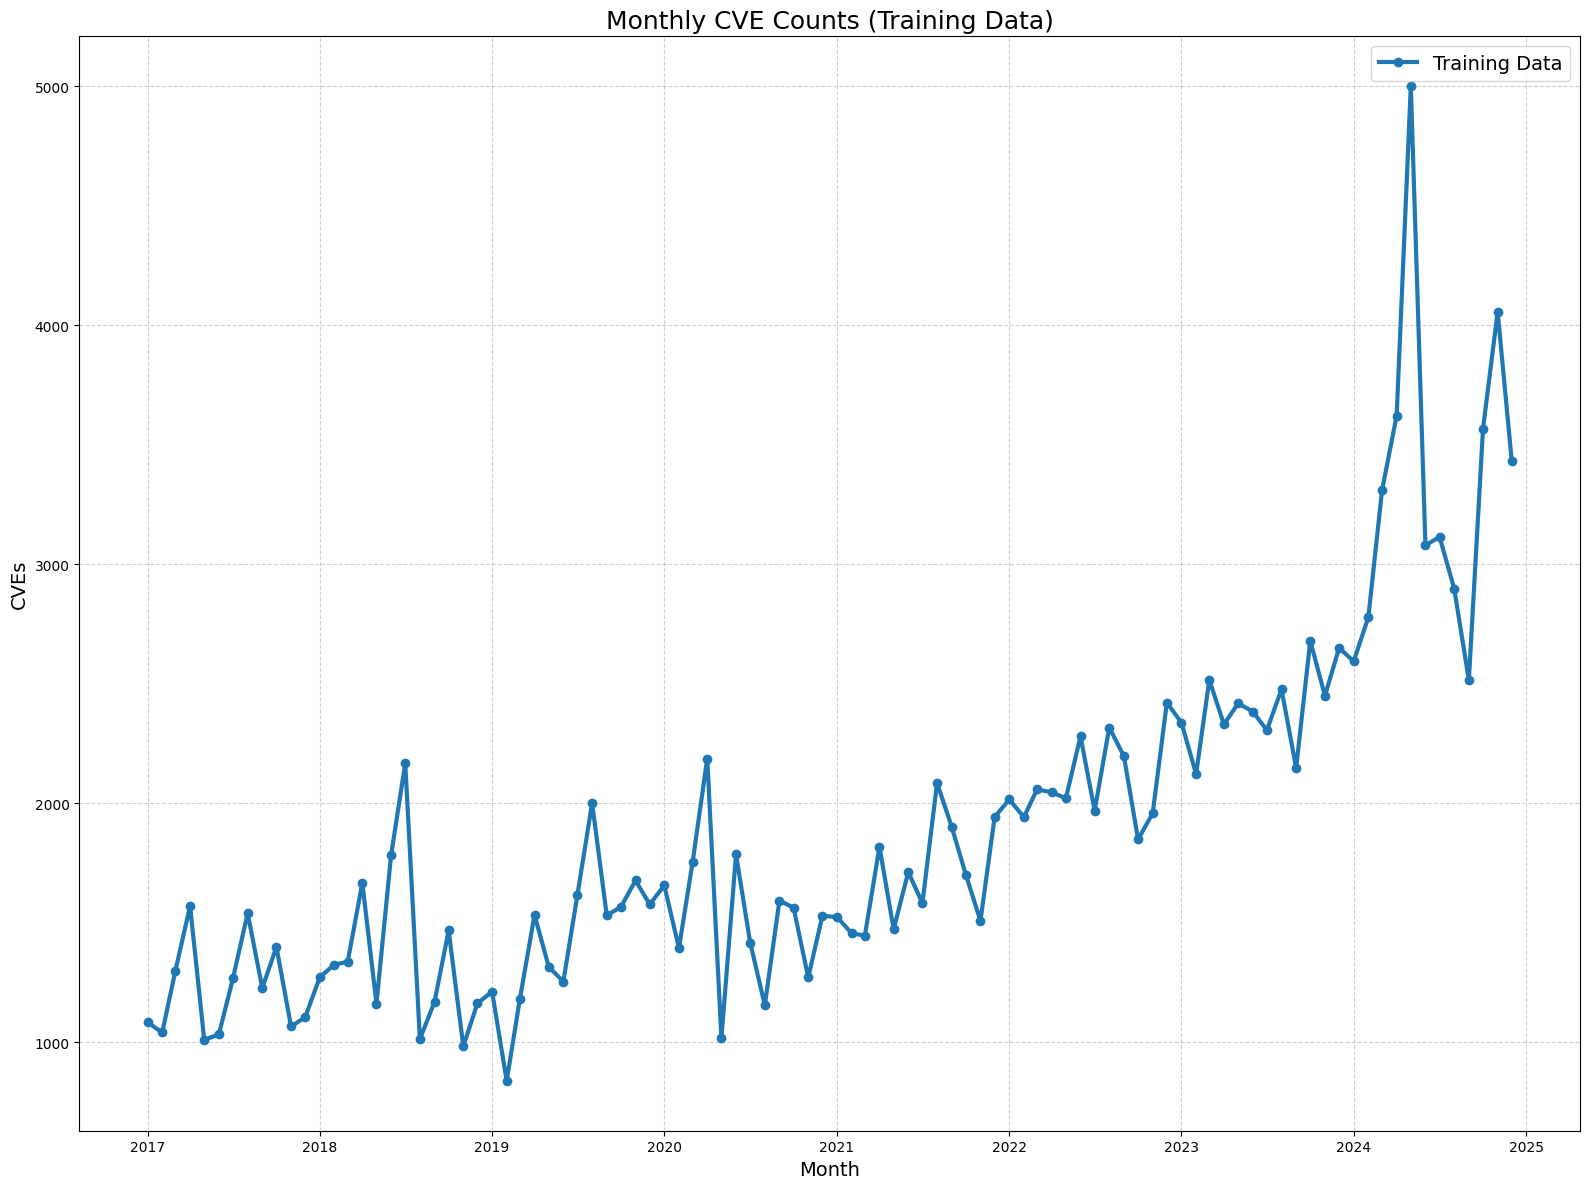

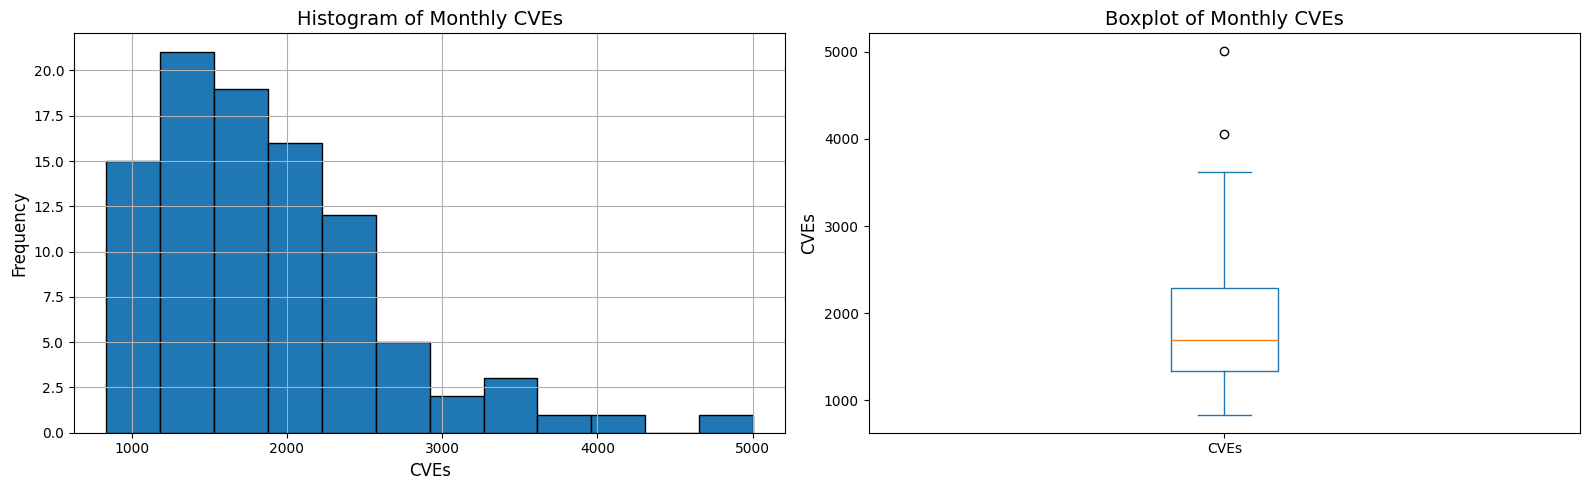

In [8]:
# Diagnostics: Check length and variance of training data
if len(monthly_cves) < 24:
    print("Warning: Time series is very short. Consider using a lower dim_x (e.g., 2 or 3) in KalmanForecaster.")
if monthly_cves['CVEs'].var() < 1e-3:
    print("Warning: Very low variance in time series. KalmanForecaster may be unstable.")

# Visual diagnostics (with error handling for headless environments)
try:
    plt.figure(figsize=(16,12))
    plt.plot(monthly_cves['Month'], monthly_cves['CVEs'], lw=3, color='#1f77b4', marker='o', label='Training Data')
    plt.title('Monthly CVE Counts (Training Data)', fontsize=18)
    plt.xlabel('Month', fontsize=14)
    plt.ylabel('CVEs', fontsize=14)
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()

    # Histogram and boxplot (use matching color)
    fig, axes = plt.subplots(1, 2, figsize=(16,5))
    monthly_cves['CVEs'].hist(ax=axes[0], bins=12, color='#1f77b4', edgecolor='black')
    axes[0].set_title('Histogram of Monthly CVEs', fontsize=14)
    axes[0].set_xlabel('CVEs', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    monthly_cves['CVEs'].plot.box(ax=axes[1], color={'boxes':'#1f77b4','whiskers':'#1f77b4','medians':'#ff7f0e','caps':'#1f77b4'})
    axes[1].set_title('Boxplot of Monthly CVEs', fontsize=14)
    axes[1].set_ylabel('CVEs', fontsize=12)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Note: Plots not displayed (likely running in headless environment): {e}")
    # Still provide text-based diagnostics
    print(f"Training data statistics:")
    print(f"  Length: {len(monthly_cves)}")
    print(f"  Mean CVEs/month: {monthly_cves['CVEs'].mean():.1f}")
    print(f"  Std deviation: {monthly_cves['CVEs'].std():.1f}")
    print(f"  Min: {monthly_cves['CVEs'].min()}")
    print(f"  Max: {monthly_cves['CVEs'].max()}")

## 6. Kalman Filter Forecasting
Fit the Kalman Forecaster model and generate predictions for the next 12 months.

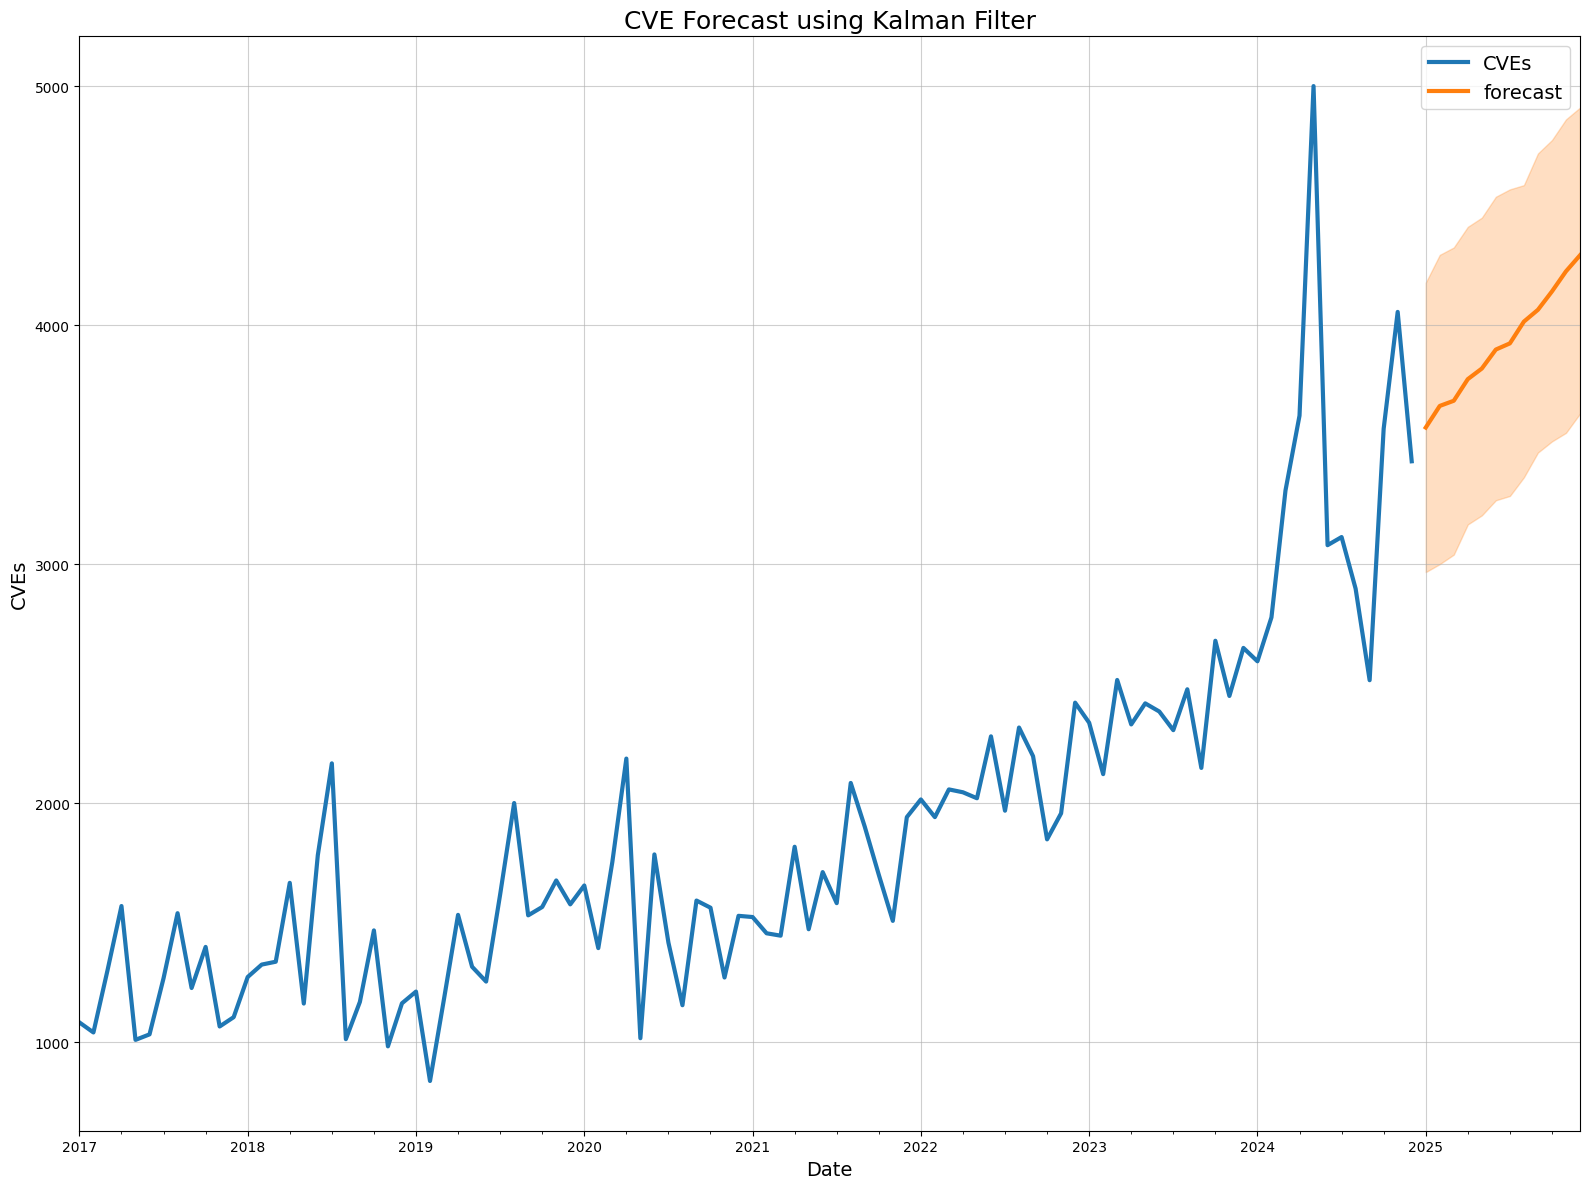

In [9]:
train = TimeSeries.from_dataframe(monthly_cves,"Month", "CVEs")
model = KalmanForecaster(dim_x=2)
model.fit(train)
# Reduced num_samples from 100000 to 1000 for faster CI execution
# This still provides good forecast quality while being much faster
pred = model.predict(n=12, num_samples=1000)

# Plot with error handling for headless environments
try:
    plt.figure(figsize=(16,12))
    train.plot(lw=3)
    pred.plot(lw=3, label='forecast')
    plt.title('CVE Forecast using Kalman Filter', fontsize=18)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('CVEs', fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(True, alpha=0.6)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Note: Forecast plot not displayed (likely running in headless environment): {e}")
    print("Forecast model trained successfully!")
    print(f"Prediction range: {pred.start_time()} to {pred.end_time()}")
    print(f"Number of forecast samples: {len(pred.all_values()[0]) if len(pred.all_values()) > 0 else 'N/A'}")

## 7. Post-Processing Forecast Results
Convert the forecast to a DataFrame and summarize monthly predictions.

In [10]:
# Extract the forecast data from the TimeSeries object
darts_df = pred.to_dataframe()

# Process the DataFrame as before
darts_monthly = darts_df.mean(axis=1).round(0)
darts_monthly = darts_monthly.to_frame()
darts_monthly = darts_monthly.reset_index()
darts_monthly = darts_monthly.rename(columns={0: "CVEs Predicted"})
darts_monthly['Month'] = darts_monthly['Month'].dt.month_name()
darts_monthly

You are transforming a stochastic TimeSeries (it contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior, extract statistics from the TimeSeries before calling `to_dataframe()` (e.g. with `TimeSeries.quantile()`, `mean()`, ...).


,Month,CVEs Predicted
0,January,3576.0
1,February,3661.0
2,March,3703.0
3,April,3775.0
4,May,3824.0
5,June,3898.0
6,July,3934.0
7,August,4005.0
8,September,4080.0
9,October,4124.0


In [11]:
darts_monthly['CVEs Predicted'].sum()

np.float64(47076.0)

## 8. Validation Against Actuals
Compare the forecasted results to actual CVE counts for 2025. Only the final validation table will be displayed below for clarity.

In [12]:
# Prepare actuals for 2025
monthly_2024 = nvd_2024['Published'].groupby(nvd_2024.Published.dt.to_period("M")).agg('count')
monthly_cves_2024 = pd.DataFrame(monthly_2024)
monthly_cves_2024.columns = ['Count']
monthly_cves_2024 = monthly_cves_2024.reset_index()
monthly_cves_2024 = monthly_cves_2024.rename(columns={"Published" : "Month" ,"Count": "CVEs Actual"})
monthly_cves_2024['Month'] = monthly_cves_2024['Month'].astype(str)
monthly_cves_2024['Month'] = pd.to_datetime(monthly_cves_2024['Month'])
monthly_cves_2024['Month'] = monthly_cves_2024['Month'].dt.month_name()

In [13]:
# Merge actuals and predictions, sort, and calculate summary statistics
validation_df = pd.merge(
    monthly_cves_2024,
    darts_monthly,
    how="outer",
    on='Month',
)

month_categories = ['January', 'February', 'March', 'April', 'May', 'June', 
                    'July', 'August', 'September', 'October', 'November', 'December', 'Total']

validation_df['Month'] = pd.Categorical(validation_df['Month'], categories = month_categories, ordered = True)
validation_df = validation_df.sort_values(by='Month')

# Calculate difference and fill missing values
validation_df['Difference'] = validation_df['CVEs Actual'] - validation_df['CVEs Predicted']
validation_df['CVEs Actual'] = validation_df['CVEs Actual'].fillna(0)
validation_df['Difference'] = validation_df['Difference'].fillna(0)

# Add total row
numeric_df = validation_df.select_dtypes(include=np.number)
total_row = numeric_df.sum(numeric_only=True)
validation_df = pd.concat([validation_df, pd.DataFrame(total_row.rename('Total')).T], ignore_index=True)
validation_df['CVEs Actual'] = validation_df['CVEs Actual'].fillna(0)
validation_df['Difference'] = validation_df['Difference'].fillna(0)

# Add percentage column

def percentage_change(col1, col2):
    return ((col2 / col1) * 100).round(0)

validation_df['Precentage'] = percentage_change(validation_df['CVEs Predicted'], validation_df['CVEs Actual'])   
validation_df['Precentage'] = validation_df['Precentage'].fillna(0)
validation_df.at[12,'Month']='Total'

# Show only the final validation table
validation_df

,Month,CVEs Actual,CVEs Predicted,Difference,Precentage
0,January,4275.0,3576.0,699.0,120.0
1,February,3675.0,3661.0,14.0,100.0
2,March,4012.0,3703.0,309.0,108.0
3,April,4034.0,3775.0,259.0,107.0
4,May,3980.0,3824.0,156.0,104.0
5,June,3681.0,3898.0,-217.0,94.0
6,July,3777.0,3934.0,-157.0,96.0
7,August,3629.0,4005.0,-376.0,91.0
8,September,4321.0,4080.0,241.0,106.0
9,October,4273.0,4124.0,149.0,104.0


## 9. Conclusion
This notebook demonstrates the use of the Kalman Filter for time series forecasting of CVE counts, with validation against actual 2025 data. Adjustments and further analysis can be performed as new data becomes available.